# Лабораторная работа 2  
## PPO + MuJoCo с фазовыми ограничениями на основе VLM

В этой работе мы настраиваем среду MuJoCo `Reacher-v4`, обучаем агента с помощью PPO
и добавляем фазовые ограничения, которые моделируют работу VLM из ДЗ1.
Фазы определяются по расстоянию до цели, но функция оформлена так, чтобы её можно было
заменить на настоящий VLM (по изображению и текстовым описаниям фаз).


In [1]:

import math
import numpy as np
import gymnasium as gym

import matplotlib.pyplot as plt
from IPython.display import HTML
import imageio

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy


## 1. Создаём базовую среду MuJoCo (Reacher-v4)


In [2]:
ENV_ID = "Reacher-v4"

def make_base_env(render_mode=None):
    # Helper to create a single MuJoCo env instance.
    env = gym.make(ENV_ID, render_mode=render_mode)
    return env

# Quick sanity check
test_env = make_base_env(render_mode=None)
print("Observation space:", test_env.observation_space)
print("Action space:", test_env.action_space)
test_env.close()


Observation space: Box(-inf, inf, (11,), float64)
Action space: Box(-1.0, 1.0, (2,), float32)


c:\Users\hormi\OneDrive\Bureau\CognArchit\lab02\.venv\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment Reacher-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 2. Определяем фазы и VLM-подобный классификатор

Мы считаем, что последняя часть вектора наблюдения Reacher-v4 хранит (target - fingertip),
и по расстоянию между ними определяем фазу:
- Phase 0: далеко от цели
- Phase 1: рядом с целью
- Phase 2: почти на цели (нужно стабилизироваться)


In [3]:
PHASE_DESCRIPTIONS = [
    "Phase 0: end-effector is far from the target",
    "Phase 1: end-effector is near the target",
    "Phase 2: end-effector is very close to the target and should stabilize",
]

def estimate_distance_from_observation(obs: np.ndarray) -> float:
    # Heuristic: in Reacher-v4, the last 2 dims approx. correspond to (target - fingertip).
    if obs.shape[0] >= 2:
        diff = obs[-2:]
    else:
        diff = obs
    return float(np.linalg.norm(diff))

def vlm_like_phase_classifier(obs: np.ndarray, phase_descriptions=None) -> int:
    if phase_descriptions is None:
        phase_descriptions = PHASE_DESCRIPTIONS

    dist = estimate_distance_from_observation(obs)

    # Thresholds for phases
    if dist > 0.2:
        phase_id = 0
    elif dist > 0.05:
        phase_id = 1
    else:
        phase_id = 2
    return phase_id


## 3. Обёртка среды с фазовыми ограничениями

Обёртка:
- вычисляет фазу на каждом шаге,
- даёт бонус при переходе в следующую фазу,
- может штрафовать за откат (здесь 0, чтобы не усложнять).


In [4]:
class PhaseConstraintWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env, phase_bonus: float = 1.0, backward_penalty: float = 0.0):
        super().__init__(env)
        self.phase_bonus = phase_bonus
        self.backward_penalty = backward_penalty

        self.phase_sequence = [0, 1, 2]
        self.current_phase = 0
        self.visited_phases = set()

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.current_phase = 0
        self.visited_phases = {0}
        phase = vlm_like_phase_classifier(obs)
        info = dict(info)
        info["phase"] = phase
        info["current_phase"] = self.current_phase
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        info = dict(info)

        phase = vlm_like_phase_classifier(obs)
        shaped_reward = reward

        # Progress to next phase
        if phase > self.current_phase:
            if phase == self.current_phase + 1:
                self.current_phase = phase
                if phase not in self.visited_phases:
                    self.visited_phases.add(phase)
                    shaped_reward += self.phase_bonus
            else:
                # Skip over phases: clip to next
                self.current_phase += 1
                if self.current_phase not in self.visited_phases:
                    self.visited_phases.add(self.current_phase)
                    shaped_reward += self.phase_bonus

        #  penalty for going back
        if phase < self.current_phase and self.backward_penalty > 0.0:
            shaped_reward -= self.backward_penalty

        info["phase"] = phase
        info["current_phase"] = self.current_phase
        info["visited_phases"] = sorted(self.visited_phases)

        return obs, shaped_reward, terminated, truncated, info


## 4. Векторизованная среда для PPO


In [5]:
def make_training_env(seed: int = 0):
    def _init():
        env = make_base_env(render_mode=None)
        env = PhaseConstraintWrapper(env, phase_bonus=1.0, backward_penalty=0.0)
        env.reset(seed=seed)
        return env
    return _init

num_envs = 4
vec_env = DummyVecEnv([make_training_env(seed=i) for i in range(num_envs)])
vec_env = VecMonitor(vec_env)


## 5. Обучение агента PPO


In [6]:
total_timesteps = 150_000

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    n_steps=2048,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    learning_rate=3e-4,
    clip_range=0.2,
    verbose=1,
)

model.learn(total_timesteps=total_timesteps)


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -59.4    |
| time/              |          |
|    fps             | 2580     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -56.8       |
| time/                   |             |
|    fps                  | 1274        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011284793 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | -0.00512    |
|    learning

## 6. Оценка политики


In [7]:
eval_env = DummyVecEnv([make_training_env(seed=123)])
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)
print(f"Mean reward over 10 episodes: {mean_reward:.2f} ± {std_reward:.2f}")


c:\Users\hormi\OneDrive\Bureau\CognArchit\lab02\.venv\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment Reacher-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
c:\Users\hormi\OneDrive\Bureau\CognArchit\lab02\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward over 10 episodes: -13.68 ± 1.44


## 7. Запись видео эпизода с фазами


Saved video to ppo_reacher_phases.mp4, episode reward = -14.50


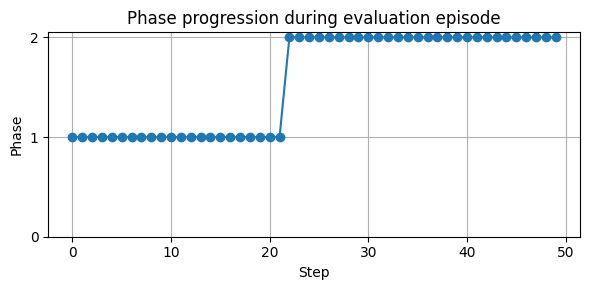

In [10]:
def record_episode_with_phases(model, max_steps=300, fps=30, video_path="ppo_reacher_phases.mp4"):
    env = make_base_env(render_mode="rgb_array")
    env = PhaseConstraintWrapper(env, phase_bonus=1.0, backward_penalty=0.0)
    obs, info = env.reset()
    frames = []
    phases = []
    total_reward = 0.0

    for step in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        phases.append(info.get("current_phase", 0))

        if terminated or truncated:
            break

    env.close()

    if frames:
        imageio.mimsave(video_path, frames, fps=fps)
        print(f"Saved video to {video_path}, episode reward = {total_reward:.2f}")
    else:
        print("No frames recorded (render_mode might not be supported).")

    return phases

phases = record_episode_with_phases(model, max_steps=300, fps=30, video_path="ppo_reacher_phases.mp4")

plt.figure(figsize=(6, 3))
plt.plot(phases, marker="o")
plt.yticks([0, 1, 2])
plt.xlabel("Step")
plt.ylabel("Phase")
plt.title("Phase progression during evaluation episode")
plt.grid(True)
plt.tight_layout()
plt.show()

HTML("""
<video width="480" controls>
<source src="ppo_reacher_phases.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>""")
